In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
from scipy.optimize import curve_fit
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

In [2]:
# Definir funciones para modelos de declinación
def decline_exponential(t, qi, di):
    """Modelo de declinación exponencial: q = qi * exp(-di * t)"""
    return qi * np.exp(-di * t)

def decline_hyperbolic(t, qi, di, b):
    """Modelo de declinación hiperbólica: q = qi / (1 + b * di * t)^(1/b)"""
    return qi / ((1 + b * di * t) ** (1/b))

def decline_harmonic(t, qi, di):
    """Modelo de declinación armónica (caso especial de hiperbólica con b=1)"""
    return qi / (1 + di * t)

In [5]:
# Crear datos de ejemplo para un pozo
def crear_datos_ejemplo(pozo_id="POZO-001", dias=365, qi=500, di=0.08, b=0.5, nivel_ruido=0.1):
    """
    Crea datos sintéticos para un pozo con una curva de declinación hiperbólica
    
    Parámetros:
    - pozo_id: Identificador del pozo
    - dias: Número de días a simular
    - qi: Producción inicial (barriles/día)
    - di: Tasa de declinación inicial
    - b: Factor de curvatura hiperbólica
    - nivel_ruido: Nivel de ruido aleatorio (0.1 = ±10%)
    """
    # Generar datos base
    dias_array = np.arange(dias)
    produccion_base = decline_hyperbolic(dias_array, qi, di, b)
    
    # Añadir ruido aleatorio
    np.random.seed(42)  # Para reproducibilidad
    ruido = np.random.uniform(1-nivel_ruido, 1+nivel_ruido, size=dias)
    produccion = produccion_base * ruido
    
    # Crear fechas
    start_date = datetime(2022, 1, 1)
    # Convertir numpy.int32 a int nativo de Python para evitar el error
    fechas = [start_date + timedelta(days=int(d)) for d in dias_array]
    
    # Crear DataFrame
    df = pd.DataFrame({
        'pozo': pozo_id,
        'fecha': fechas,
        'produccion': produccion,
        'dias_produccion': dias_array
    })
    
    return df

In [6]:
# 1. Generar datos de ejemplo
datos = crear_datos_ejemplo(pozo_id="POZO-001", dias=365, qi=500, di=0.08, b=0.5)

# Mostrar primeras filas
print("Primeros registros del pozo:")

# Visualizar las estadísticas básicas
print("\nEstadísticas del pozo:")
print(datos['produccion'].describe())

Primeros registros del pozo:

Estadísticas del pozo:
count    365.000000
mean      32.587757
std       70.842828
min        1.948918
25%        3.562333
50%        7.303698
75%       23.912237
max      503.949178
Name: produccion, dtype: float64


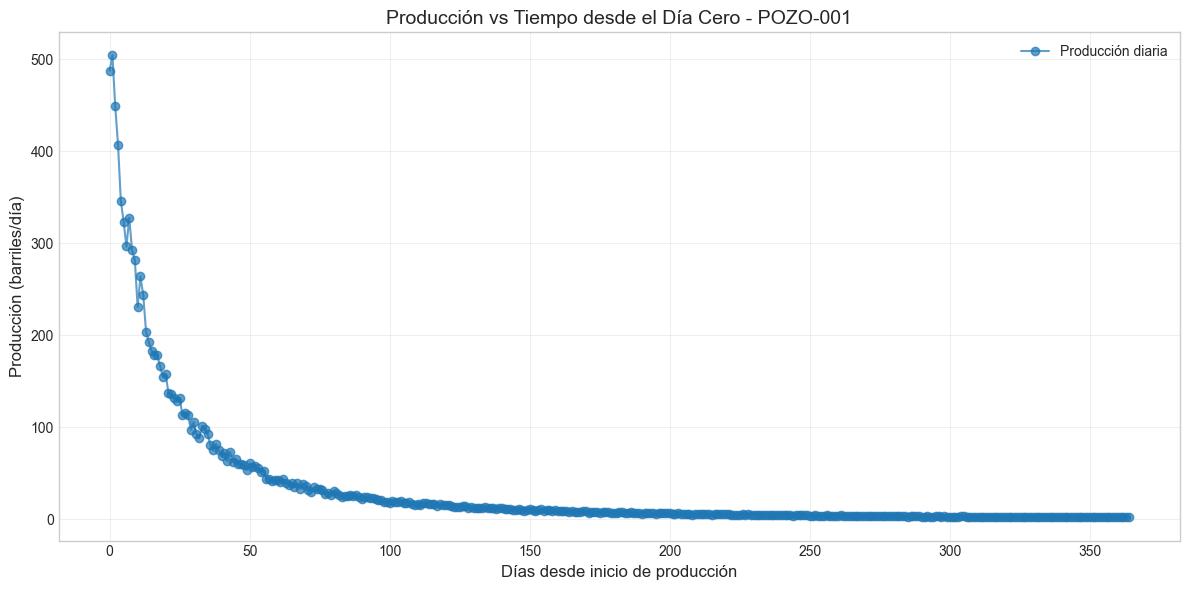

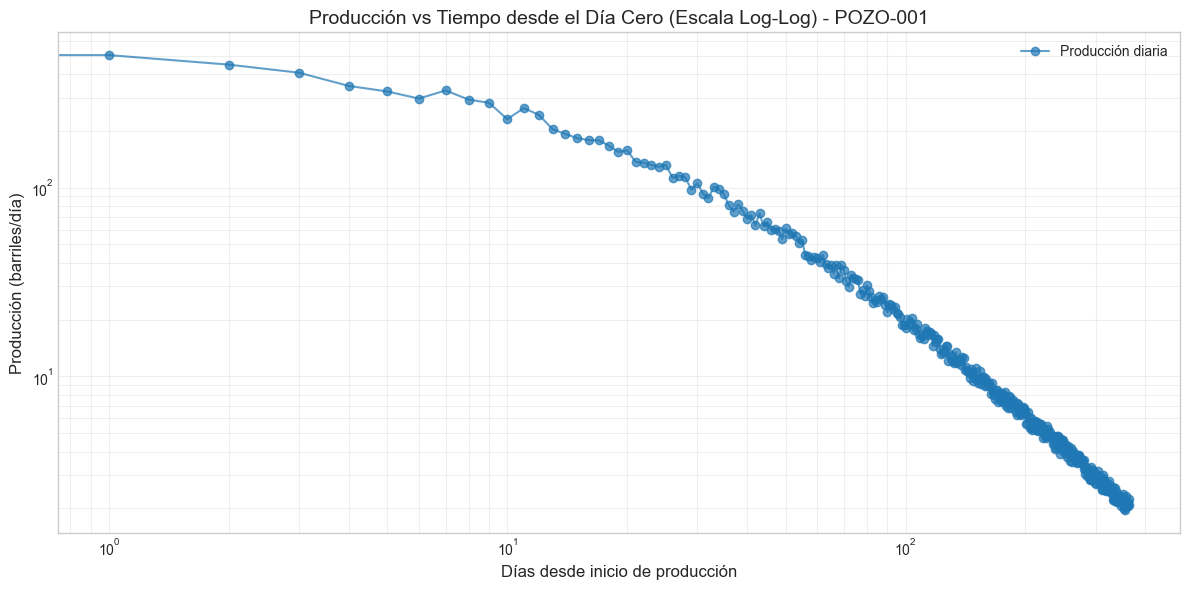

In [7]:
# 2. Visualizar producción vs. tiempo
plt.figure(figsize=(12, 6))
plt.plot(datos['dias_produccion'], datos['produccion'], 'o-', alpha=0.7, label='Producción diaria')

plt.title('Producción vs Tiempo desde el Día Cero - POZO-001')
plt.xlabel('Días desde inicio de producción')
plt.ylabel('Producción (barriles/día)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Visualizar en escala logarítmica
plt.figure(figsize=(12, 6))
plt.plot(datos['dias_produccion'], datos['produccion'], 'o-', alpha=0.7, label='Producción diaria')

plt.title('Producción vs Tiempo desde el Día Cero (Escala Log-Log) - POZO-001')
plt.xlabel('Días desde inicio de producción')
plt.ylabel('Producción (barriles/día)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# 4. Ajustar modelos de declinación
# Preparar datos
dias_array = datos['dias_produccion'].values
produccion = datos['produccion'].values

In [9]:
# Ajustar modelo exponencial
p0_exp = [produccion.max(), 0.1]  # Valores iniciales (qi, di)
bounds_exp = ([0, 0], [np.inf, 1])
popt_exp, _ = curve_fit(decline_exponential, dias_array, produccion, p0=p0_exp, bounds=bounds_exp)
qi_exp, di_exp = popt_exp

# Ajustar modelo hiperbólico
p0_hyp = [produccion.max(), 0.1, 0.5]  # Valores iniciales (qi, di, b)
bounds_hyp = ([0, 0, 0], [np.inf, 1, 2])
popt_hyp, _ = curve_fit(decline_hyperbolic, dias_array, produccion, p0=p0_hyp, bounds=bounds_hyp)
qi_hyp, di_hyp, b_hyp = popt_hyp

# Ajustar modelo armónico
p0_harm = [produccion.max(), 0.1]  # Valores iniciales (qi, di)
bounds_harm = ([0, 0], [np.inf, 1])
popt_harm, _ = curve_fit(decline_harmonic, dias_array, produccion, p0=p0_harm, bounds=bounds_harm)
qi_harm, di_harm = popt_harm

print("\nParámetros ajustados para cada modelo:")
print(f"Exponencial: qi = {qi_exp:.2f} bpd, di = {di_exp:.4f}")
print(f"Hiperbólico: qi = {qi_hyp:.2f} bpd, di = {di_hyp:.4f}, b = {b_hyp:.2f}")
print(f"Armónico: qi = {qi_harm:.2f} bpd, di = {di_harm:.4f}")


Parámetros ajustados para cada modelo:
Exponencial: qi = 440.70 bpd, di = 0.0471
Hiperbólico: qi = 508.92 bpd, di = 0.0846, b = 0.52
Armónico: qi = 572.76 bpd, di = 0.1631


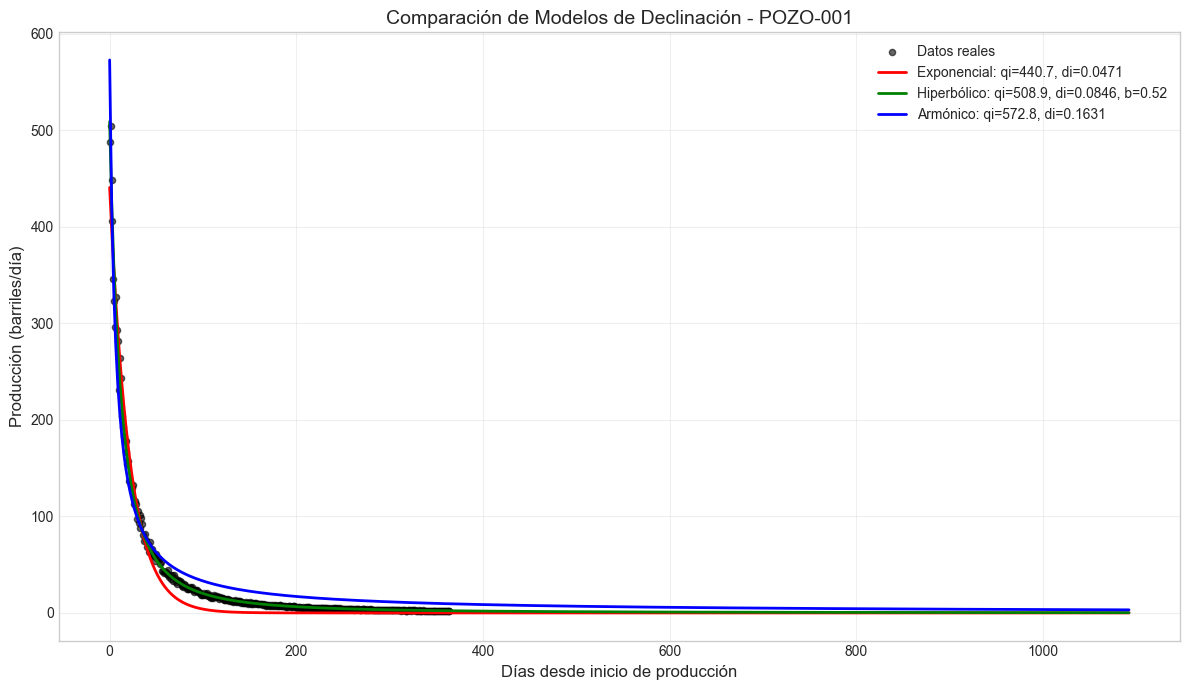

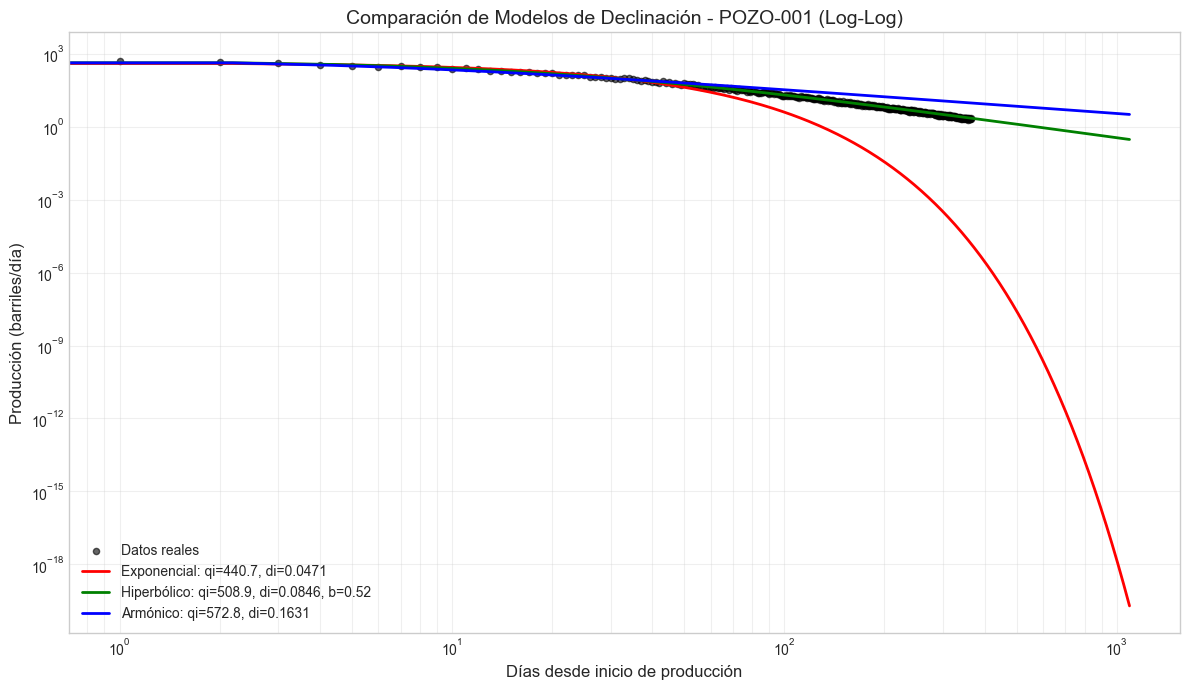

In [10]:
# 5. Proyectar y comparar modelos
# Crear proyección futura (3 años)
dias_futuros = np.linspace(0, dias_array.max() * 3, 500)
prod_exp = decline_exponential(dias_futuros, qi_exp, di_exp)
prod_hyp = decline_hyperbolic(dias_futuros, qi_hyp, di_hyp, b_hyp)
prod_harm = decline_harmonic(dias_futuros, qi_harm, di_harm)

# Graficar comparación de modelos
plt.figure(figsize=(12, 7))
plt.scatter(dias_array, produccion, c='black', label='Datos reales', alpha=0.6, s=20)
plt.plot(dias_futuros, prod_exp, 'r-', label=f'Exponencial: qi={qi_exp:.1f}, di={di_exp:.4f}', linewidth=2)
plt.plot(dias_futuros, prod_hyp, 'g-', label=f'Hiperbólico: qi={qi_hyp:.1f}, di={di_hyp:.4f}, b={b_hyp:.2f}', linewidth=2)
plt.plot(dias_futuros, prod_harm, 'b-', label=f'Armónico: qi={qi_harm:.1f}, di={di_harm:.4f}', linewidth=2)

plt.title('Comparación de Modelos de Declinación - POZO-001')
plt.xlabel('Días desde inicio de producción')
plt.ylabel('Producción (barriles/día)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# En escala logarítmica
plt.figure(figsize=(12, 7))
plt.scatter(dias_array, produccion, c='black', label='Datos reales', alpha=0.6, s=20)
plt.plot(dias_futuros, prod_exp, 'r-', label=f'Exponencial: qi={qi_exp:.1f}, di={di_exp:.4f}', linewidth=2)
plt.plot(dias_futuros, prod_hyp, 'g-', label=f'Hiperbólico: qi={qi_hyp:.1f}, di={di_hyp:.4f}, b={b_hyp:.2f}', linewidth=2)
plt.plot(dias_futuros, prod_harm, 'b-', label=f'Armónico: qi={qi_harm:.1f}, di={di_harm:.4f}', linewidth=2)

plt.title('Comparación de Modelos de Declinación - POZO-001 (Log-Log)')
plt.xlabel('Días desde inicio de producción')
plt.ylabel('Producción (barriles/día)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# 6. Calcular EUR (Estimated Ultimate Recovery) para cada modelo
# Proyectar a 30 años
dias_proyeccion = np.linspace(0, 365 * 30, 10000)  # 30 años
eur_exp = np.trapz(decline_exponential(dias_proyeccion, qi_exp, di_exp), dias_proyeccion)
eur_hyp = np.trapz(decline_hyperbolic(dias_proyeccion, qi_hyp, di_hyp, b_hyp), dias_proyeccion)
eur_harm = np.trapz(decline_harmonic(dias_proyeccion, qi_harm, di_harm), dias_proyeccion)

print("\nEstimación de Recuperación Final (EUR) a 30 años por modelo:")
print(f"Exponencial: {eur_exp:.0f} barriles")
print(f"Hiperbólico: {eur_hyp:.0f} barriles")
print(f"Armónico: {eur_harm:.0f} barriles")


Estimación de Recuperación Final (EUR) a 30 años por modelo:
Exponencial: 9352 barriles
Hiperbólico: 12599 barriles
Armónico: 26311 barriles


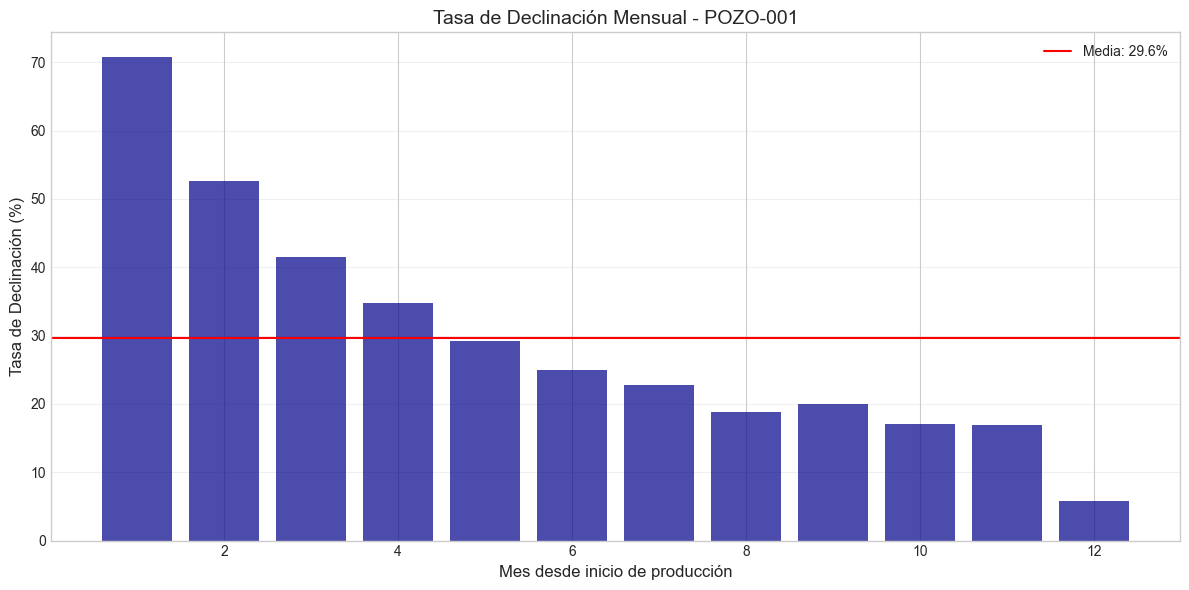

In [12]:
# 7. Análisis de tasa de declinación mensual
# Agrupar datos por mes
datos['mes'] = datos['dias_produccion'] // 30
datos_mensuales = datos.groupby('mes')['produccion'].mean().reset_index()

# Calcular tasas de declinación mensual
datos_mensuales['prod_anterior'] = datos_mensuales['produccion'].shift(1)
datos_mensuales = datos_mensuales.dropna()
datos_mensuales['tasa_declinacion'] = (datos_mensuales['prod_anterior'] - datos_mensuales['produccion']) / datos_mensuales['prod_anterior'] * 100  # En porcentaje

# Graficar tasa de declinación mensual
plt.figure(figsize=(12, 6))
plt.bar(datos_mensuales['mes'], datos_mensuales['tasa_declinacion'], alpha=0.7, color='darkblue')
plt.axhline(y=datos_mensuales['tasa_declinacion'].mean(), color='r', linestyle='-', 
           label=f'Media: {datos_mensuales["tasa_declinacion"].mean():.1f}%')

plt.title('Tasa de Declinación Mensual - POZO-001')
plt.xlabel('Mes desde inicio de producción')
plt.ylabel('Tasa de Declinación (%)')
plt.grid(True, alpha=0.3, axis='y')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 8. Crear una función para cargar y analizar datos reales
def analizar_pozo_real(ruta_archivo, id_pozo, fecha_col='fecha', prod_col='produccion'):
    """
    Carga y analiza datos reales de un pozo
    
    Parámetros:
    - ruta_archivo: Ruta al archivo CSV o Excel
    - id_pozo: ID del pozo a analizar
    - fecha_col: Nombre de la columna de fecha
    - prod_col: Nombre de la columna de producción
    """
    # Cargar datos
    if ruta_archivo.endswith('.csv'):
        df = pd.read_csv(ruta_archivo)
    elif ruta_archivo.endswith(('.xls', '.xlsx')):
        df = pd.read_excel(ruta_archivo)
    else:
        raise ValueError("Formato de archivo no soportado. Use CSV o Excel.")
    
    # Filtrar para el pozo específico
    if 'pozo' in df.columns:
        df = df[df['pozo'] == id_pozo]
    
    # Convertir fechas
    df[fecha_col] = pd.to_datetime(df[fecha_col])
    
    # Normalizar al día cero
    fecha_inicio = df[fecha_col].min()
    df['dias_produccion'] = (df[fecha_col] - fecha_inicio).dt.days
    
    # Ordenar por día de producción
    df = df.sort_values('dias_produccion')
    
    # Ejecutar análisis (similar al código anterior)
    # ...
    
    return df

In [ ]:
# Ejemplo de cómo utilizar esta función:
# datos_reales = analizar_pozo_real("mi_archivo.csv", "POZO-123")

print("\n¡Análisis completo! Ahora puedes adaptar este código para tus datos reales.")